In [1]:
import os
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from mbtrack2.impedance.wakefield import WakeField
from mbtrack2.tracking import LongitudinalMap, SynchrotronRadiation, TransverseMap
from mbtrack2.tracking import Beam, Bunch, WakePotential
from mbtrack2.tracking import RFCavity, SynchrotronRadiation
from mbtrack2.tracking.monitors import BunchMonitor, WakePotentialMonitor
from mbtrack2.tracking.feedback import FIRDamper, ExponentialDamper
from machine_data.TDR2 import *
from machine_data.soleil import v2366, v2366_v2, v2366_v3
from SOLEILII_parameters.SOLEILII_TDR_parameters import *

def run_mbtrack2(
    n_turns=100_000,
    n_macroparticles=int(1e5),
    n_bin=100,
    bunch_current=1.2e-3,
    Qp_x=1.6,
    Qp_y=1.6,
    id_state="close",
    include_Zlong="False",
    harmonic_cavity="False",
    max_kick=0.0e+00,
    sc='False'
):
    ring2 = v2366_v3(IDs=id_state, V_RF = 1.7e6, HC_power=50e3)
    particle = Electron()
    chro = [Qp_x, Qp_y]
    ring = Synchrotron(
        h=ring2.h,
        optics=ring2.optics,
        particle=particle,
        L=ring2.L,
        E0=ring2.E0,
        ac=ring2.ac,
        U0=ring2.U0,
        tau=ring2.tau,
        emit=ring2.emit,
        tune=ring2.tune,
        sigma_delta=ring2.sigma_delta,
        sigma_0=ring2.sigma_0,
        chro=chro,
    )
    mybunch = Bunch(
        ring, mp_number=n_macroparticles, current=bunch_current, track_alive=False
    )
    np.random.seed(42)
    mybunch.init_gaussian()
    stdx, stdy = np.std(mybunch['x']), np.std(mybunch['y'])
    monitor_filename = "monitors(n_mp={:.1e},n_turns={:.1e},n_bin={:},bunch_current={:.1e},Qp_x={:.2f},Qp_y={:.2f},id_state={:},Zlong={:},cavity={:},max_kick={:.1e},sc={:})".format(
        n_macroparticles,
        n_turns,
        n_bin,
        bunch_current,
        Qp_x,
        Qp_y,
        id_state,
        include_Zlong,
        harmonic_cavity,
        max_kick,
        sc
    )
    bunch_monitor = BunchMonitor(
        0,
        save_every=1,
        buffer_size=1000,
        total_size=n_turns,
        file_name=monitor_filename,
        mpi_mode=False,
    )
    long_map = LongitudinalMap(ring)
    if harmonic_cavity == "False":
        rf = RFCavity(ring, m=1, Vc=V_RF, theta=np.arccos(ring.U0 / V_RF))
    if harmonic_cavity == "True":
        V_RF_main, theta_main, V_RF_harmonic, theta_harmonic = get_active_cavity_params(ring)
        main_rf = RFCavity(ring, m=1, Vc=V_RF_main, theta=theta_main)
        harmonic_rf = RFCavity(ring, m=4, Vc=V_RF_harmonic, theta=theta_harmonic)
    sr = SynchrotronRadiation(ring, switch=[0, 0, 0])
    trans_map = TransverseMap(ring)
    wakemodel = load_TDR2_wf(version=("TDR2.1_ID" + id_state))
    wakefield_long = WakePotential(ring, wakefield=WakeField([wakemodel.Wlong]), n_bin=n_bin)
    
    # fbty = FIRDamper(ring,
    #                 plane='y',
    #                 tune=ring.tune[1],
    #                 turn_delay=0,
    #                 tap_number=7,
    #                 gain=1,
    #                 phase=270,
    #                 bpm_error=None,
    #                 max_kick=max_kick)
    # fbtx = FIRDamper(ring,
    #                 plane='x',
    #                 tune=ring.tune[0],
    #                 turn_delay=0,
    #                 tap_number=7,
    #                 gain=1,
    #                 phase=270,
    #                 bpm_error=None,
    #                 max_kick=max_kick)
    feedback_tau = 100
    
    fbty = ExponentialDamper(ring, plane='y', damping_time=ring.T0*feedback_tau, phase_diff=np.pi/2)
    fbtx = ExponentialDamper(ring, plane='x', damping_time=ring.T0*feedback_tau, phase_diff=np.pi/2)

    tracking_elements = [trans_map, long_map, bunch_monitor]
    if max_kick > 0:
        tracking_elements.append(fbtx)
        tracking_elements.append(fbty)
    if harmonic_cavity == "True":
        print("Harmonic cavity is on.")
        tracking_elements.append(main_rf)
        tracking_elements.append(harmonic_rf)
        
    else:
        print("Harmonic cavity is off.")
        tracking_elements.append(rf)
    if include_Zlong == 'True':
        print("Longitudinal impedance included.")
        tracking_elements.append(wakefield_long)

    monitor_count = 0
    mybunch['y'] += 1e-6
    print(np.mean(mybunch['y']))
    print(tracking_elements)
    for i in tqdm(range(n_turns)):
        for el in tracking_elements:
            el.track(mybunch)

In [2]:
run_mbtrack2(
    n_turns=2000,
    n_macroparticles=100_000,
    n_bin=100,
    bunch_current=1.2e-3,
    Qp_x=0,
    Qp_y=0,
    id_state='close',
    include_Zlong='False',
    harmonic_cavity='False',
    max_kick=1.0e-9,
    sc='False'
)

Harmonic cavity is off.
1.003132012315147e-06
[<mbtrack2.tracking.element.TransverseMap object at 0x7dafbac63ac0>, <mbtrack2.tracking.element.LongitudinalMap object at 0x7dafb817b3d0>, <mbtrack2.tracking.monitors.monitors.BunchMonitor object at 0x7dafb832ca00>, <mbtrack2.tracking.feedback.ExponentialDamper object at 0x7dafb83acb80>, <mbtrack2.tracking.feedback.ExponentialDamper object at 0x7dafb83ac850>, <mbtrack2.tracking.rf.RFCavity object at 0x7dafb817b370>]


  0%|          | 0/2000 [00:00<?, ?it/s]

-3.113139145065126e-07


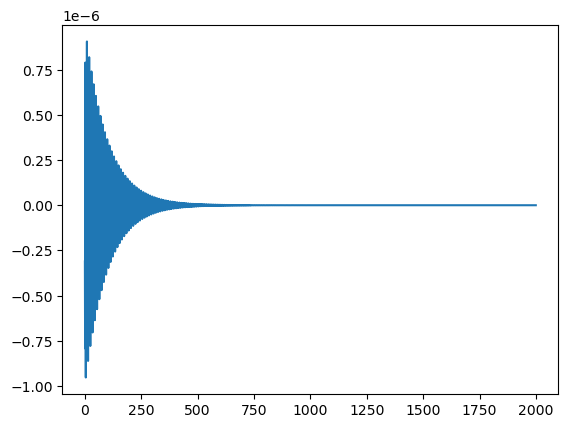

In [6]:
%matplotlib inline
import h5py as hp
f = hp.File('monitors(n_mp=1.0e+05,n_turns=2.0e+03,n_bin=100,bunch_current=1.2e-03,Qp_x=0.00,Qp_y=0.00,id_state=close,Zlong=False,cavity=False,max_kick=1.0e-09,sc=False).hdf5')
y = f['BunchData_0']['mean'][2,:]
print(y[0])
f.close()
plt.plot(y)

(array([2.0000e+00, 7.0000e+00, 2.3000e+01, 6.5000e+01, 2.4600e+02,
        6.5500e+02, 1.5160e+03, 2.8730e+03, 5.1490e+03, 8.1990e+03,
        1.1124e+04, 1.3354e+04, 1.4110e+04, 1.3355e+04, 1.0824e+04,
        7.9240e+03, 5.1920e+03, 2.9480e+03, 1.4390e+03, 6.4800e+02,
        2.2500e+02, 8.2000e+01, 3.4000e+01, 4.0000e+00, 2.0000e+00]),
 array([0.00099273, 0.00099331, 0.0009939 , 0.00099448, 0.00099506,
        0.00099564, 0.00099623, 0.00099681, 0.00099739, 0.00099797,
        0.00099855, 0.00099914, 0.00099972, 0.0010003 , 0.00100088,
        0.00100147, 0.00100205, 0.00100263, 0.00100321, 0.0010038 ,
        0.00100438, 0.00100496, 0.00100554, 0.00100613, 0.00100671,
        0.00100729]),
 <BarContainer object of 25 artists>)

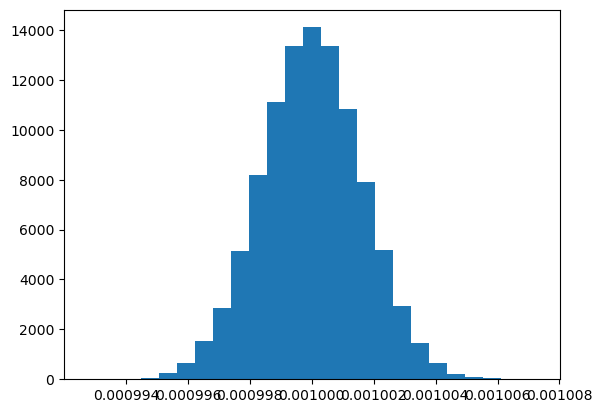

In [7]:
id_state='close'
ring2 = v2366_v3(IDs=id_state, V_RF = 1.7e6, HC_power=50e3)
particle = Electron()
chro = [0, 0]
ring = Synchrotron(
        h=ring2.h,
        optics=ring2.optics,
        particle=particle,
        L=ring2.L,
        E0=ring2.E0,
        ac=ring2.ac,
        U0=ring2.U0,
        tau=ring2.tau,
        emit=ring2.emit,
        tune=ring2.tune,
        sigma_delta=ring2.sigma_delta,
        sigma_0=ring2.sigma_0,
        chro=chro,
    )
mybunch = Bunch(
    ring, mp_number=1e5, current=1.2e-3, track_alive=False
    )
np.random.seed(42)
mybunch.init_gaussian()
mybunch['y'] += 1e-3
plt.hist(mybunch['y'], bins=25)